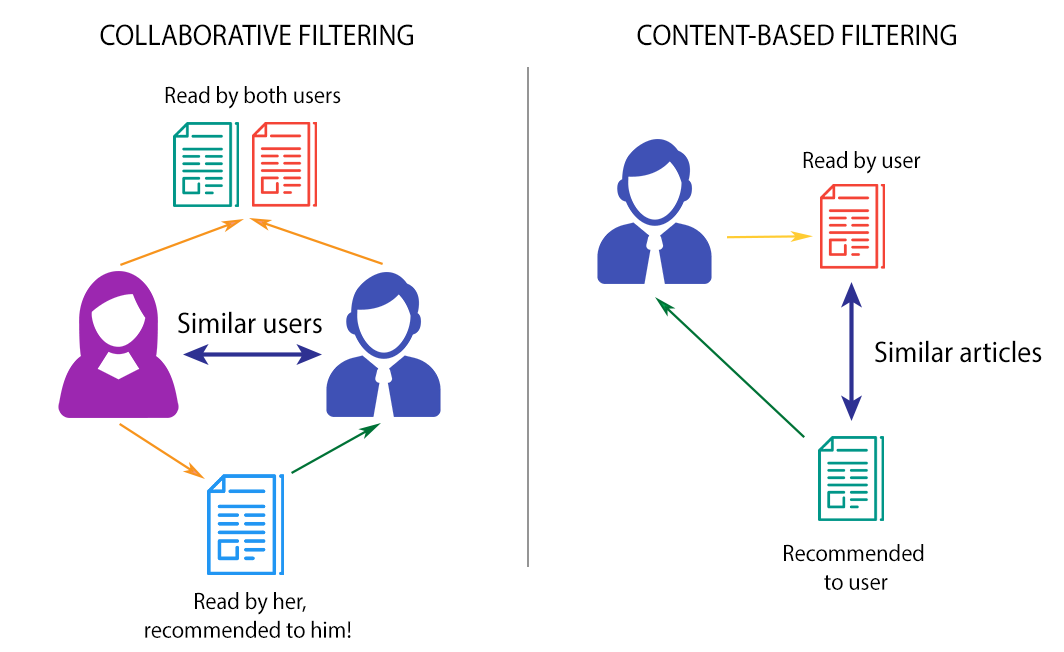

# CONTENT BASED FILTERING

Simply, it is the recommendation of a product with similar content according to the content of the product/service.

The Content-based approach requires a good amount of information about items’ features, rather than using the user’s interactions and feedback.

**Advantage:**

- The model doesn't need any data about other users, since the recommendations are specific to this user. This makes it easier to scale to a large number of users.


**Disadvantage:**
 
- The model can only make recommendations based on existing interests of the user. In other words, the model has limited ability to expand on the users' existing interests.



  *In this study, a recommendation system model will be built based on the content definitions of the recipes and the content of the recipe steps.

In [2]:
import pandas as pd

pd.set_option('display.max_columns',None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from textblob import Word, TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('RAW_recipes.csv')

In [4]:
df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [5]:
df['steps'] = df['steps'].str.replace('[^\w\s]', '')

In [6]:
print('Head of Description\n\n', df['description'].head(10))
print('=' *70)
print('Tail of Description\n\n', df['description'].tail(10))

Head of Description

 0    autumn is my favorite time of year to cook! th...
1    this recipe calls for the crust to be prebaked...
2    this modified version of 'mom's' chili was a h...
3    this is a super easy, great tasting, make ahea...
4    my dh's amish mother raised him on this recipe...
5                                                  NaN
6    my italian mil was thoroughly impressed by my ...
7    this recipe is posted by request and was origi...
8                                                  NaN
9                                  from ann hodgman's 
Name: description, dtype: object
Tail of Description

 231627                      a delicious bacon-studded tart.
231628    haricots verts are very slender french green b...
231629    recipe courtesy of b&c seafood, vacherie, la a...
231630    great sauce for cheeseburgers or dipping fries...
231631               a wrap inspired by great cajun flavors
231632    this is a delicious soup that i originally fou...
231633      t

In [7]:
print('Head of Steps\n\n', df['steps'].head(10))
print('=' *70)
print('Tail of Steps\n\n', df['steps'].tail(10))

Head of Steps

 0    make a choice and proceed with recipe dependin...
1    preheat oven to 425 degrees f press dough into...
2    brown ground beef in large pot add chopped oni...
3    place potatoes in a large pot of lightly salte...
4    mix all ingredients boil for 2 1  2 hours  or ...
5    combine ingredients in blender cover and blend...
6    toast the fennel seeds and lightly crush them ...
7    in a medium saucepan combine all the ingredien...
8    crumble cookies into a 9inch pie plate  or cak...
9    preheat oven to 350 degrees butter two 9x5 loa...
Name: steps, dtype: object
Tail of Steps

 231627    crust pulse flour  baking powder  and salt in ...
231628    into each of six sterile pint mason jars  put ...
231629    place the lettuce on a platter or serving dish...
231630    to make the sauce  combine the mayonnaise  hor...
231631    bring 3 quarts salted to water to a boil add i...
231632    heat oil in a 4quart dutch oven add celery  on...
231633              mix all ing

In [8]:
df.dropna(inplace=True)

In [9]:
random_foods = pd.Series(df['id']).sample(50000, random_state=17).values.tolist()
random_food_df = df[df['id'].isin(random_foods)].reset_index(drop=True)

**Note**  
It will be sampled so that the computer performance does not affect the study.

In [10]:
random_food_df.shape

(50000, 12)

**TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents.  
They are used to determine the relative importance of a document / article / news item / movie etc.**

In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}

In [12]:
def preprocess_sentences(text):
    text = text.lower()
    temp_sent =[]
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)
    for i, word in enumerate(words):
        if tags[i][1] in VERB_CODES: 
            lemmatized = lemmatizer.lemmatize(word, 'v')
        else:
            lemmatized = lemmatizer.lemmatize(word)
        if lemmatized not in stop_words:
            temp_sent.append(lemmatized)
          
    finalsent = ' '.join(temp_sent)
    finalsent = finalsent.replace("n't", " not")
    finalsent = finalsent.replace("'m", " am")
    finalsent = finalsent.replace("'s", " is")
    finalsent = finalsent.replace("'re", " are")
    finalsent = finalsent.replace("'ll", " will")
    finalsent = finalsent.replace("'ve", " have")
    finalsent = finalsent.replace("'d", " would")
    return finalsent

In [13]:
df['steps'][7]

'in a medium saucepan combine all the ingredients for sauce1  bring to a full rolling boil  reduce heat to medium low and simmer for 1 hour  stirring often rub the ribs with soy sauce  garlic  ginger  chili powder  pepper  salt and chopped cilantro  both sides  wrap ribs in heavy duty foil let stand 1 hour preheat oven to 350 degrees place ribs in oven for 1 hour  turning once after 30 minutes 3 times during cooking the ribs open foil wrap and drizzle ribs with sauce1 place all the ingredients for sauce2 in a glass or plastic bowl  whisk well and set aside remove ribs from oven and place on serving platter offer both sauces at table to drizzle over ribs'

In [14]:
df['steps'] = df['steps'].apply(preprocess_sentences)

In [15]:
df['steps'][7]

'medium saucepan combine ingredient sauce1 bring full rolling boil reduce heat medium low simmer 1 hour stir often rub rib soy sauce garlic ginger chili powder pepper salt chop cilantro side wrap rib heavy duty foil let stand 1 hour preheat oven 350 degree place rib oven 1 hour turn 30 minute 3 time cook rib open foil wrap drizzle rib sauce1 place ingredient sauce2 glass plastic bowl whisk well set aside remove rib oven place serve platter offer sauce table drizzle rib'

**Some Changes**

- ingredients >> ingredient
- stirring >> stir 
- ribs >> rib

In [16]:
df['description'][63]

"it's a fun finger food for infants and toddlers that packs a little calcium and vitamin punch. try vegetarian cream cheese and soy yogurt for the lactose intolerant child or children not yet introduced to milk products. cook time is approximate chill time. servings are dependent on size of squares or shapes cut, but we cut the pan into 5 rows and 5 columns, yielding 25 squares."

In [17]:
df['description'] = df['description'].apply(preprocess_sentences)

In [18]:
df['description'][63]

' is fun finger food infant toddler pack little calcium vitamin punch . try vegetarian cream cheese soy yogurt lactose intolerant child child yet introduce milk product . cook time approximate chill time . serving dependent size square shape cut , cut pan 5 row 5 column , yield 25 square .'

**Some Changes**

- toddlers >> toddler
- products >> product 

## Recommendations Based on Recipe Steps

In [19]:
tfidf = TfidfVectorizer()

**TfidfVectorizer - Transforms text to feature vectors that can be used as input to estimator.**

In [20]:
tfidf_matrix = tfidf.fit_transform(random_food_df['steps'])

In [21]:
tfidf_matrix.shape

(50000, 24897)

**There are 50000 recipes in our dataset. Columns consist of words in descriptions.**

In [22]:
random_food_df['steps'].shape

(50000,)

In [23]:
tfidf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
cosine_sim = cosine_similarity(tfidf_matrix,
                               tfidf_matrix)

In [25]:
cosine_sim.shape

(50000, 50000)

**Cosine similarity measures the similarity between two vectors of an inner product space.  
We can say that the purpose of use in this study is to measure the similarity of 50000 recipes with each other.**

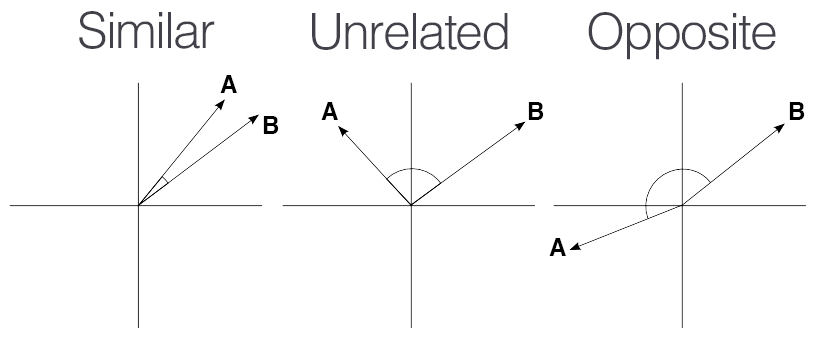

In [26]:
indices = pd.Series(random_food_df.index, index=random_food_df['name'])

In [27]:
indices

name
all in the kitchen  chili                           0
chicken lickin  good  pork chops                    1
chinese  chop suey                                  2
global gourmet  taco casserole                      3
grilled  venison burgers                            4
                                                ...  
zupse bread swiss bread                         49995
zurich diced veal zurcher geschnetzeltes        49996
zurie s holey rustic olive and cheddar bread    49997
zwetschgenkuchen   plum cake                    49998
zydeco shrimp wrap                              49999
Length: 50000, dtype: int64

In [28]:
indices.index.value_counts()

homemade pop tarts                      2
hot chicken dip                         2
old fashioned macaroni and cheese       2
cheddar bay biscuits  red lobster       2
russian style salad dressing            2
                                       ..
easy mediterranean pasta salad          1
easy melt in your mouth coconut cake    1
easy meringue topping                   1
easy mexican pozole soup  crock pot     1
zydeco shrimp wrap                      1
Name: name, Length: 49935, dtype: int64

In [29]:
indices = indices[~indices.index.duplicated(keep='last')]

In [30]:
def check_food(keyword):
    return [col for col in random_food_df.name if keyword in col]

**Determining the recipe to recommendation**

In [31]:
check_food('chicken breasts')[:20]

['apple bacon stuffed chicken breasts',
 'artichoke stuffed chicken breasts',
 'asian grilled chicken breasts',
 'asian style chicken breasts and bacon',
 'bacon and cheese stuffed chicken breasts',
 'bacon wrapped chicken breasts',
 'bacon wrapped smoked gouda stuffed chicken breasts',
 'baked buffalo chicken breasts',
 'baked chicken breasts and rice',
 'baked chicken breasts in red wine  easy',
 'baked chicken breasts with almond sauce',
 'baked chicken breasts with cornbread stuffing',
 'baked chicken breasts with garlic and oregano',
 'baked chicken breasts with gravy',
 'baked chicken breasts with horseradish cream sauce',
 'baked chicken breasts with parmesan garlic crust',
 'baked chicken breasts with parmesan garlic crust',
 'baked herb crusted chicken breasts',
 'baked stuffed boneless chicken breasts',
 'baked tarragon chicken breasts']

In [32]:
food_index = indices['bacon wrapped chicken breasts']

In [33]:
cosine_sim[food_index]

array([0.06157347, 0.09536556, 0.10841632, ..., 0.17992045, 0.09020662,
       0.20072078])

**The similarity scores of the chosen recipe with other recipes are checked.**

In [34]:
similarity_scores = pd.DataFrame(cosine_sim[food_index],
                                 columns=['score'])

In [35]:
food_indices = similarity_scores.sort_values('score', ascending=False)[1:11].index

### 10 recipes most similar to the chosen recipe

In [36]:
random_food_df['name'].iloc[food_indices]

13423                         creamy bacon wrapped chicken
10015                    chicken with homemade herb cheese
10073                                        chicken yeffa
9366     chicken breast wrapped in bacon with mushroom ...
12826                         cousin cosmo s greek chicken
15814                       double dipped chicken parmesan
29124                             microwave romano chicken
20978    greek style lemony chicken breasts with kalama...
49717                         zesty cheesy crumbed chicken
14438                        crocked bacon wrapped chicken
Name: name, dtype: object

**Recommendations appear to make sense**

In [37]:
check_food('avocado salad')[:20]

['almond crumbed chicken schnitzel with avocado salad',
 'asparagus  artichoke  and avocado salad',
 'asparagus  snap pea and avocado salad',
 'avocado salad with tomato relish',
 'avocado salad with warm tomato basil vinaigrette',
 'bacon tomato and avocado salad',
 'celery and avocado salad',
 'cherry tomato avocado salad',
 'chicken  bacon and avocado salad',
 'corn  tomato and avocado salad',
 'corn  tomato  and avocado salad',
 'curried potato  chicken and avocado salad',
 'dandelion greens  or arugula  and avocado salad',
 'eggplant  aubergine    avocado salad',
 'orange avocado salad with poppy seed dressing',
 'papaya avocado salad',
 'pineapple chicken w  black bean avocado salad',
 'potato avocado salad',
 'roasted carrot and avocado salad',
 'simple papaya avocado salad']

In [38]:
food_index = indices['asparagus  artichoke  and avocado salad']
similarity_scores = pd.DataFrame(cosine_sim[food_index],
                                 columns=['score'])
food_indices = similarity_scores.sort_values('score', ascending=False)[1:11].index

### Recommendations for asparagus artichoke  and avocado salad 

In [39]:
random_food_df['name'].iloc[food_indices]

16124                            east west asparagus salad
16684                             easy marinated asparagus
2191                                asparagus walnut salad
18739                       fresh balsamic asparagus salad
2139                              asparagus   tomato salad
10332                        chilled asparagus with pecans
694                                           al khurshoof
42904          spring salad with buttermilk cream dressing
43336                           strawberry asparagus salad
28173    marinated artichoke hearts  shrimp  and mushrooms
Name: name, dtype: object

## Preparation of Working Script

In [40]:
def calculate_cosine_sim(dataframe, col):
    tfidf = TfidfVectorizer(stop_words='english')
    dataframe[col] = dataframe[col].fillna('')
    tfidf_matrix = tfidf.fit_transform(dataframe[col])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    return cosine_sim

def recommendation(recipe, cosine_sim, dataframe):
    indices = pd.Series(dataframe.index, index=dataframe['name'])
    indices = indices[~indices.index.duplicated(keep='last')]
    food_index = indices[recipe]
    similarity_scores = pd.DataFrame(cosine_sim[food_index],
                                 columns=["score"])
    food_indices = similarity_scores.sort_values("score", ascending=False)[1:11].index
    return dataframe['name'].iloc[food_indices]

**Note**   
The reason why I specified the col parameter is that there are other columns in the data set that I can make recommendations by using their content.

## Recommendations Based on Recipe Descriptions

In [41]:
cosine_sim = calculate_cosine_sim(random_food_df, 'description')

In [42]:
check_food('vodka')[:20]

['absolut hunk vodka martini',
 'andreas viestad s vodka marinated sirloin',
 'blue cheese vodka balls  finger food',
 'cherry tomatoes marinated in vodka  in oversized martini glass',
 'connecticut pasta with vodka sauce',
 'cranberry and vodka sparkle',
 'cranberry vodka delight',
 'cranberry lime vodka punch',
 'cucumber  kumquat  and mint vodka cocktail',
 'delicious penne vodka with fresh mushrooms  mozzarella  olives',
 'dirty vodka martini w blue cheese olives',
 'easiest penne with vodka',
 'firebird s honey vodka',
 'foolproof pie dough  with vodka',
 'fresh pineapple infused vodka',
 'fruit vodka slush',
 'ginger vodka',
 'grandma bea s vodka slush',
 'linda s lemon shrimp a la vodka pasta',
 'lobster ravioli with a light tomato vodka sauce']

In [43]:
recommendation('dirty vodka martini w blue cheese olives', cosine_sim, random_food_df)

18149                 filthy martini
1599               apple pie martini
33375                  peach martini
29195    mike s butterscotch martini
28741             melon ball martini
46715            traditional martini
20866                     greek mama
26426     lemon vanilla mint martini
79                      007  martini
27047             london sun martini
Name: name, dtype: object

In [44]:
recs = recommendation('dirty vodka martini w blue cheese olives', cosine_sim, random_food_df).values.tolist()

In [45]:
print(f"Ingredients: {random_food_df.loc[random_food_df['name'] == 'dirty vodka martini w blue cheese olives', 'ingredients'].values}")

Ingredients: ["['blue cheese', 'dry vermouth', 'vodka', 'spanish olives', 'ice']"]


In [46]:
for rec in recs:
    print(f"Recipe {rec}  :\n  Ingredients: {random_food_df.loc[random_food_df['name'] == rec, 'ingredients'].values} \n {'='*80}")

Recipe filthy martini  :
  Ingredients: ["['vodka', 'brine', 'dry vermouth', 'capers']"] 
Recipe apple pie martini  :
  Ingredients: ["['vodka', 'goldschlager', 'apple juice', 'cranberry juice', 'apple']"] 
Recipe peach martini  :
  Ingredients: ["['peach juice', 'ice cubes', 'vodka', 'disaronno liquor']"] 
Recipe mike s butterscotch martini  :
  Ingredients: ["['vanilla vodka', 'butterscotch schnapps', 'ice cubes']"] 
Recipe melon ball martini  :
  Ingredients: ["['citrus-infused vodka', 'midori melon liqueur', 'orange juice']"] 
Recipe traditional martini  :
  Ingredients: ["['vodka', 'dry vermouth', 'olive']"] 
Recipe greek mama  :
  Ingredients: ["['frangelico', 'ouzo', 'dark rum']"] 
Recipe lemon vanilla mint martini  :
  Ingredients: ["['lemon', 'sugar', 'ice', 'vanilla vodka', 'mint leaf']"] 
Recipe 007  martini  :
  Ingredients: ["['dry vermouth', 'vodka', 'gin', 'lillet blanc']"] 
Recipe london sun martini  :
  Ingredients: ["['dry gin', 'dry sherry', 'orange bitters', 'lemon 

**The ingredients appear to be quite close to each other.**

In [47]:
check_food('cookies')[:30]

['1 in canada chocolate chip cookies',
 'you can t eat just one  ice box cookies',
 'new  vanishing oatmeal raisin cookies',
 '101 super cookies',
 '3 ingredient peanut butter cookies',
 '5 chip cookies',
 '60 sec  chocolate oat peanut butter cookies',
 'absolutely the best chocolate chip cookies',
 'absolutely the best gluten free peanut butter cookies',
 'addictive white chocolate cookies',
 'agave oatmeal raisin flax cookies',
 'alaska molasses cookies',
 'all american chewy chocolate chip cookies',
 'almond bar cookies',
 'almond blueberry cookies',
 'almond butter cookies with frosting',
 'almond chocolate cookies',
 'almond cloud cookies',
 'almond crescent cookies',
 'almond joy cookies',
 'almond kiss cookies',
 'almond meringue cookies',
 'almond toffee cookies',
 'almond vanilla cookies',
 'almost flourless chocolate chocolate chip peanut butter cookies',
 'aloha cookies',
 'amaretti cookies',
 'amaretti cookies  no flour and low fat',
 'amaretto apricot cookies',
 'amaretto 

In [48]:
recommendation('almost flourless chocolate chocolate chip peanut butter cookies', cosine_sim, random_food_df)

6934                  butterless peanut butter cookies
290                 3 ingredient peanut butter cookies
4993                   best peanut butter cookies ever
33522    peanut butter chip    chocolate chip pancakes
31078                   no flour peanut butter cookies
9038             chewy chocolate peanut butter cookies
1429                apple butter peanut butter cookies
11002                     chocolate peanut butter cake
24737                 jean pare s peanut butter treats
48557          weight watcher s general tsao s chicken
Name: name, dtype: object

**AS A RESULT**, we can see that both models have got successful results. We can also say that the quantity and quality of information contained in the text have a large share in finding items that are close to each other.